# Group Normalization - Image Data

## Giới thiệu

Group Normalization (GN) là một kỹ thuật normalization được giới thiệu trong paper "Group Normalization" của Yuxin Wu và Kaiming He. Đối với dữ liệu ảnh, thường có shape (batch, channels, height, width).

Group Normalization sẽ normalize theo:
- Chia channels thành các groups
- Normalize trong mỗi group (theo channel và spatial dimensions trong group đó)
- Không phụ thuộc vào batch size
- Áp dụng cho từng sample độc lập

## Công thức

```
# Chia channels thành num_groups groups
group_size = channels / num_groups
mean = mean(x, dim=(1, 2, 3))  # Tính mean theo group channels, height, width
var = var(x, dim=(1, 2, 3))    # Tính variance theo group channels, height, width
x_norm = (x - mean) / sqrt(var + eps)
output = gamma * x_norm + beta
```

Trong đó:
- num_groups: số lượng groups để chia channels
- gamma: learnable scale parameter (một cho mỗi channel)
- beta: learnable shift parameter (một cho mỗi channel)
- eps: small constant để tránh chia cho 0

Group Normalization hoạt động tốt với batch size nhỏ và không phụ thuộc vào batch statistics.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class GroupNorm2D:
    """
    Group Normalization cho 2D image data (4D tensor: batch, channels, height, width)
    """
    def __init__(self, num_channels, num_groups, eps=1e-5):
        self.num_channels = num_channels
        self.num_groups = num_groups
        self.eps = eps
        
        # Kiểm tra num_channels chia hết cho num_groups
        assert num_channels % num_groups == 0, f"num_channels ({num_channels}) phải chia hết cho num_groups ({num_groups})"
        
        self.group_size = num_channels // num_groups
        
        # Learnable parameters
        self.gamma = np.ones(num_channels)  # Scale
        self.beta = np.zeros(num_channels)  # Shift
        
    def forward(self, x):
        """
        x shape: (batch, channels, height, width)
        """
        batch_size, num_channels, height, width = x.shape
        output = np.zeros_like(x)
        
        # Reshape để group channels
        # Shape: (batch, num_groups, group_size, height, width)
        x_grouped = x.reshape(batch_size, self.num_groups, self.group_size, height, width)
        
        # Tính mean và var theo group channels, height, width
        # Keep dims: batch, num_groups
        mean = np.mean(x_grouped, axis=(2, 3, 4), keepdims=True)
        var = np.var(x_grouped, axis=(2, 3, 4), keepdims=True)
        
        # Normalize
        x_norm_grouped = (x_grouped - mean) / np.sqrt(var + self.eps)
        
        # Reshape lại về shape ban đầu
        x_norm = x_norm_grouped.reshape(batch_size, num_channels, height, width)
        
        # Scale and shift
        gamma = self.gamma.reshape(1, -1, 1, 1)
        beta = self.beta.reshape(1, -1, 1, 1)
        output = gamma * x_norm + beta
        
        return output

print("GroupNorm2D class đã được định nghĩa!")


GroupNorm2D class đã được định nghĩa!


## Ví dụ 1: 1 Sample, 1 Kernel (Channel)

Shape: (1, 1, 4, 4) - 1 batch, 1 channel, 4x4 image

Với 1 channel, num_groups phải là 1.


Input shape: (1, 1, 4, 4)
Input data:
[[  9.96714153   3.61735699  11.47688538  20.23029856]
 [  2.65846625   2.65863043  20.79212816  12.67434729]
 [  0.30525614  10.42560044   0.36582307   0.34270246]
 [  7.41962272 -14.13280245 -12.24917833  -0.62287529]]

Input mean: 4.7456
Input std: 9.4022

Output shape: (1, 1, 4, 4)
Output data:
[[ 0.55535368 -0.11999629  0.71592692  1.64692188]
 [-0.22198193 -0.22196447  1.70667691  0.8432865 ]
 [-0.4722645   0.60411443 -0.46582272 -0.46828178]
 [ 0.28440484 -2.0078666  -1.80752823 -0.57097864]]

Output mean: 0.0000
Output std: 1.0000


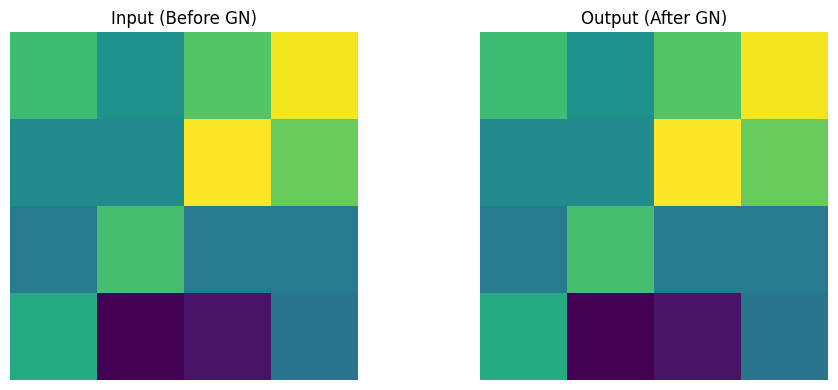

In [2]:
# Ví dụ 1: 1 Sample, 1 Kernel
np.random.seed(42)
x1 = np.random.randn(1, 1, 4, 4) * 10 + 5  # 1 batch, 1 channel, 4x4
print(f"Input shape: {x1.shape}")
print(f"Input data:\n{x1[0, 0]}")
print(f"\nInput mean: {np.mean(x1):.4f}")
print(f"Input std: {np.std(x1):.4f}")

# Khởi tạo GroupNorm với 1 group
gn1 = GroupNorm2D(num_channels=1, num_groups=1)

# Forward pass
output1 = gn1.forward(x1)
print(f"\nOutput shape: {output1.shape}")
print(f"Output data:\n{output1[0, 0]}")
print(f"\nOutput mean: {np.mean(output1):.4f}")
print(f"Output std: {np.std(output1):.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(x1[0, 0], cmap='viridis')
axes[0].set_title('Input (Before GN)')
axes[0].axis('off')

axes[1].imshow(output1[0, 0], cmap='viridis')
axes[1].set_title('Output (After GN)')
axes[1].axis('off')
plt.tight_layout()
plt.show()


## Ví dụ 2: 1 Sample, 2 Kernels (Channels)

Shape: (1, 2, 4, 4) - 1 batch, 2 channels, 4x4 image

Với 2 channels, có thể chia thành 1 hoặc 2 groups.


Input shape: (1, 2, 4, 4)

Channel 0 mean: 4.7456, std: 9.4022
Channel 1 mean: 2.5083, std: 9.0820

Output shape: (1, 2, 4, 4)

Channel 0 - Output mean: 0.0000, std: 1.0000
Channel 1 - Output mean: 0.0000, std: 1.0000


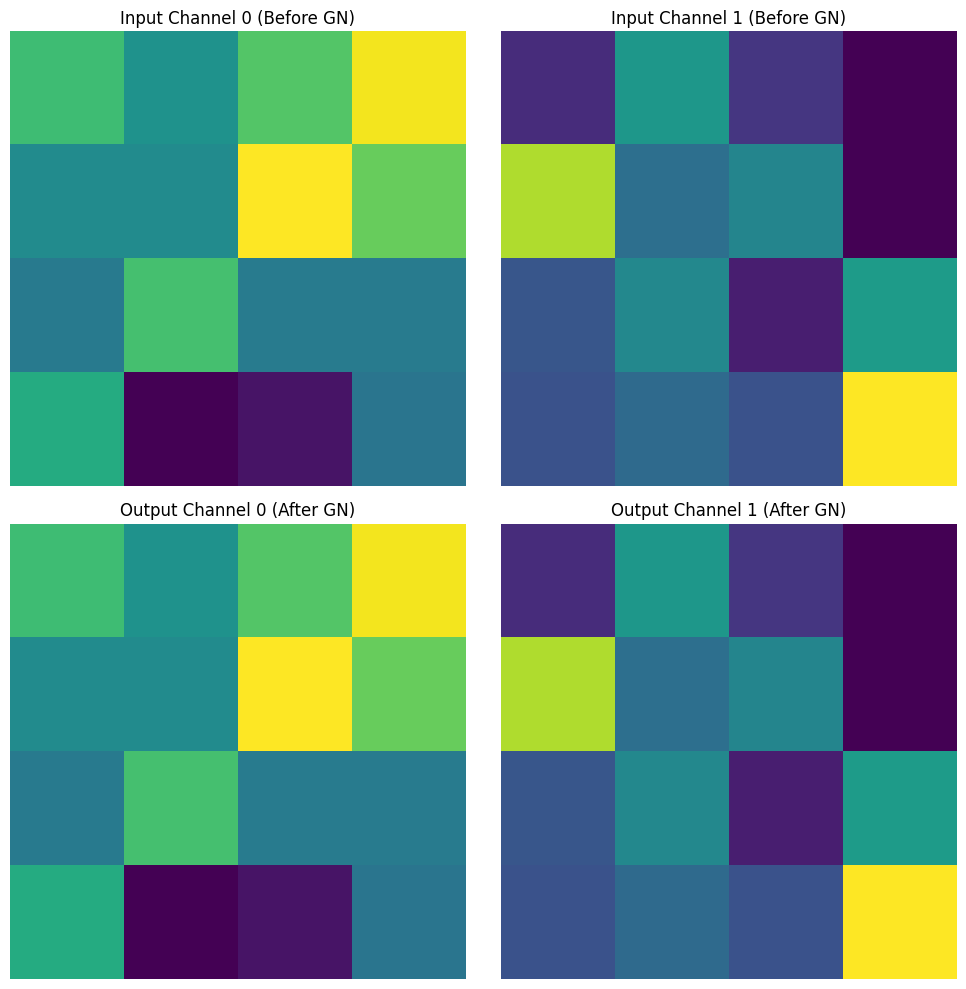

In [3]:
# Ví dụ 2: 1 Sample, 2 Kernels
np.random.seed(42)
x2 = np.random.randn(1, 2, 4, 4) * 10 + 5  # 1 batch, 2 channels, 4x4
print(f"Input shape: {x2.shape}")
print(f"\nChannel 0 mean: {np.mean(x2[0, 0]):.4f}, std: {np.std(x2[0, 0]):.4f}")
print(f"Channel 1 mean: {np.mean(x2[0, 1]):.4f}, std: {np.std(x2[0, 1]):.4f}")

# Khởi tạo GroupNorm với 2 groups (mỗi group 1 channel)
gn2 = GroupNorm2D(num_channels=2, num_groups=2)

# Forward pass
output2 = gn2.forward(x2)
print(f"\nOutput shape: {output2.shape}")
print(f"\nChannel 0 - Output mean: {np.mean(output2[0, 0]):.4f}, std: {np.std(output2[0, 0]):.4f}")
print(f"Channel 1 - Output mean: {np.mean(output2[0, 1]):.4f}, std: {np.std(output2[0, 1]):.4f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(x2[0, 0], cmap='viridis')
axes[0, 0].set_title('Input Channel 0 (Before GN)')
axes[0, 0].axis('off')

axes[0, 1].imshow(x2[0, 1], cmap='viridis')
axes[0, 1].set_title('Input Channel 1 (Before GN)')
axes[0, 1].axis('off')

axes[1, 0].imshow(output2[0, 0], cmap='viridis')
axes[1, 0].set_title('Output Channel 0 (After GN)')
axes[1, 0].axis('off')

axes[1, 1].imshow(output2[0, 1], cmap='viridis')
axes[1, 1].set_title('Output Channel 1 (After GN)')
axes[1, 1].axis('off')
plt.tight_layout()
plt.show()


## Ví dụ 3: 2 Samples, 1 Kernel (Channel)

Shape: (2, 1, 4, 4) - 2 batches, 1 channel, 4x4 image

Trong trường hợp này, GroupNorm sẽ normalize từng sample độc lập.


Input shape: (2, 1, 4, 4)

Sample 0 mean: 4.7456, std: 9.4022
Sample 1 mean: 2.5083, std: 9.0820

Output shape: (2, 1, 4, 4)

Sample 0 - Output mean: 0.0000, std: 1.0000
Sample 1 - Output mean: 0.0000, std: 1.0000


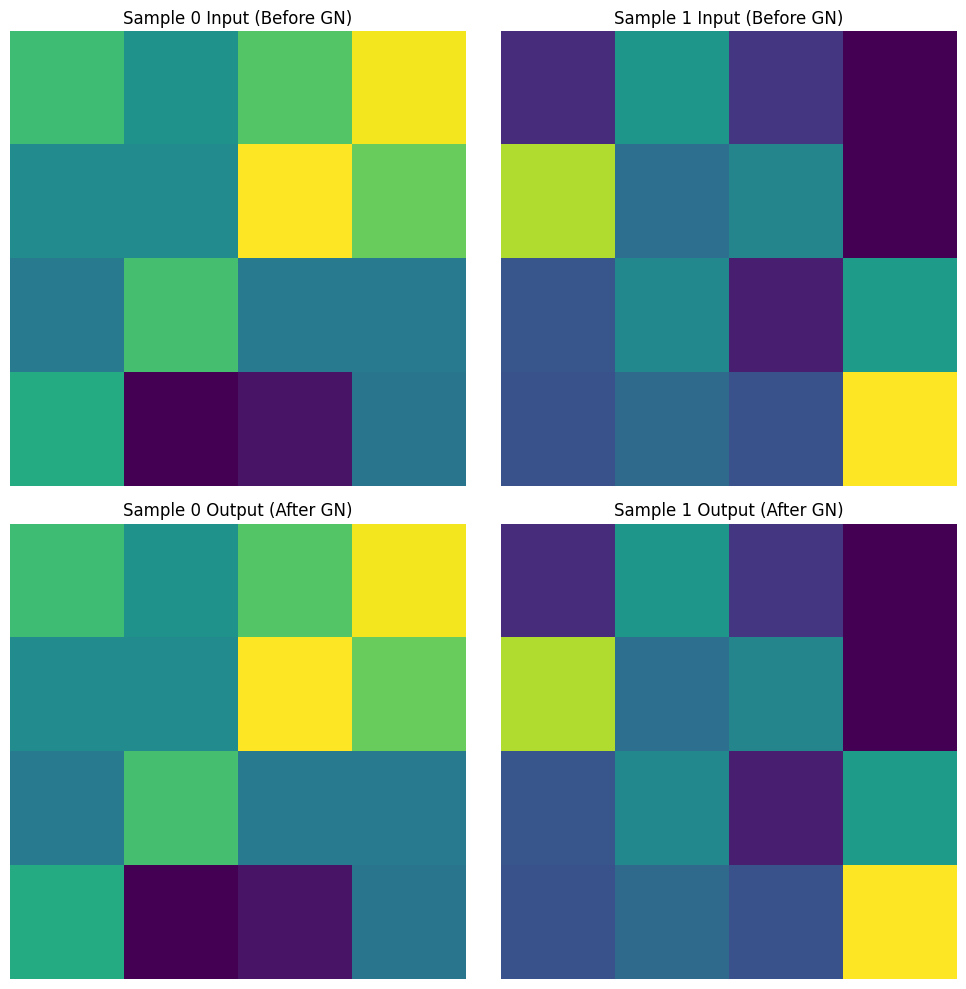

In [4]:
# Ví dụ 3: 2 Samples, 1 Kernel
np.random.seed(42)
x3 = np.random.randn(2, 1, 4, 4) * 10 + 5  # 2 batches, 1 channel, 4x4
print(f"Input shape: {x3.shape}")
print(f"\nSample 0 mean: {np.mean(x3[0]):.4f}, std: {np.std(x3[0]):.4f}")
print(f"Sample 1 mean: {np.mean(x3[1]):.4f}, std: {np.std(x3[1]):.4f}")

# Khởi tạo GroupNorm với 1 group
gn3 = GroupNorm2D(num_channels=1, num_groups=1)

# Forward pass
output3 = gn3.forward(x3)
print(f"\nOutput shape: {output3.shape}")
print(f"\nSample 0 - Output mean: {np.mean(output3[0]):.4f}, std: {np.std(output3[0]):.4f}")
print(f"Sample 1 - Output mean: {np.mean(output3[1]):.4f}, std: {np.std(output3[1]):.4f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(x3[0, 0], cmap='viridis')
axes[0, 0].set_title('Sample 0 Input (Before GN)')
axes[0, 0].axis('off')

axes[0, 1].imshow(x3[1, 0], cmap='viridis')
axes[0, 1].set_title('Sample 1 Input (Before GN)')
axes[0, 1].axis('off')

axes[1, 0].imshow(output3[0, 0], cmap='viridis')
axes[1, 0].set_title('Sample 0 Output (After GN)')
axes[1, 0].axis('off')

axes[1, 1].imshow(output3[1, 0], cmap='viridis')
axes[1, 1].set_title('Sample 1 Output (After GN)')
axes[1, 1].axis('off')
plt.tight_layout()
plt.show()


## Ví dụ 4: 2 Samples, 2 Kernels (Channels)

Shape: (2, 2, 4, 4) - 2 batches, 2 channels, 4x4 image

Đây là trường hợp đầy đủ nhất. GroupNorm sẽ chia 2 channels thành groups và normalize trong mỗi group.


Input shape: (2, 2, 4, 4)
Sample 0, Channel 0 - mean: 4.7456, std: 9.4022
Sample 0, Channel 1 - mean: 2.5083, std: 9.0820
Sample 1, Channel 0 - mean: 1.5872, std: 8.5957
Sample 1, Channel 1 - mean: 3.5048, std: 8.1643

Output shape: (2, 2, 4, 4)
Sample 0, Channel 0 - Output mean: 0.0000, std: 1.0000
Sample 0, Channel 1 - Output mean: 0.0000, std: 1.0000
Sample 1, Channel 0 - Output mean: 0.0000, std: 1.0000
Sample 1, Channel 1 - Output mean: 0.0000, std: 1.0000


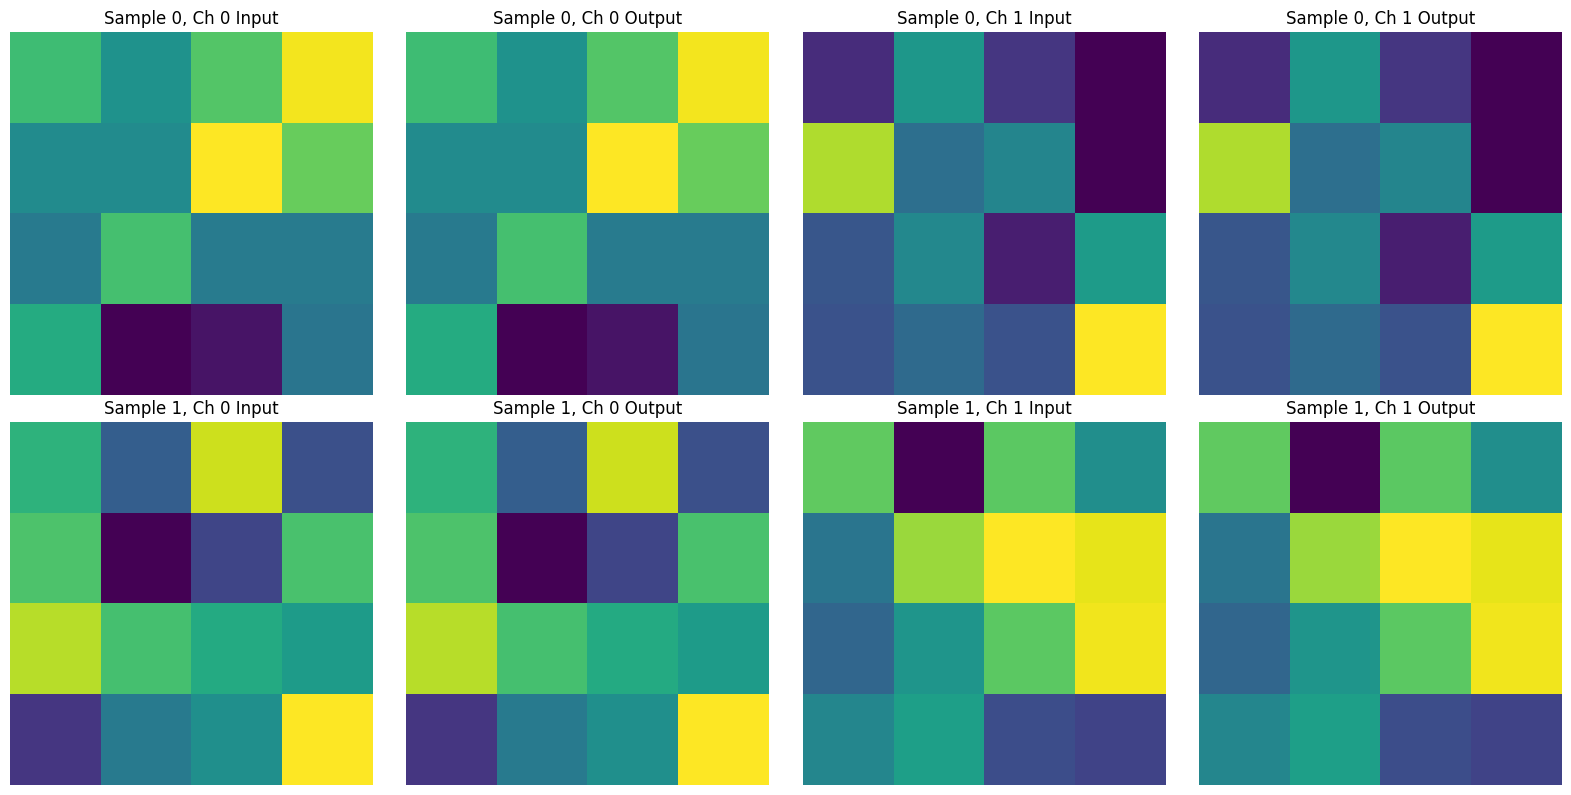

In [5]:
# Ví dụ 4: 2 Samples, 2 Kernels
np.random.seed(42)
x4 = np.random.randn(2, 2, 4, 4) * 10 + 5  # 2 batches, 2 channels, 4x4
print(f"Input shape: {x4.shape}")

for b in range(2):
    for c in range(2):
        print(f"Sample {b}, Channel {c} - mean: {np.mean(x4[b, c]):.4f}, std: {np.std(x4[b, c]):.4f}")

# Khởi tạo GroupNorm với 2 groups (mỗi group 1 channel)
gn4 = GroupNorm2D(num_channels=2, num_groups=2)

# Forward pass
output4 = gn4.forward(x4)
print(f"\nOutput shape: {output4.shape}")

for b in range(2):
    for c in range(2):
        print(f"Sample {b}, Channel {c} - Output mean: {np.mean(output4[b, c]):.4f}, std: {np.std(output4[b, c]):.4f}")

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for b in range(2):
    for c in range(2):
        axes[b, c*2].imshow(x4[b, c], cmap='viridis')
        axes[b, c*2].set_title(f'Sample {b}, Ch {c} Input')
        axes[b, c*2].axis('off')
        
        axes[b, c*2+1].imshow(output4[b, c], cmap='viridis')
        axes[b, c*2+1].set_title(f'Sample {b}, Ch {c} Output')
        axes[b, c*2+1].axis('off')

plt.tight_layout()
plt.show()
